In [1]:
%load_ext autoreload

%autoreload 2

In [19]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch as tc
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.datasets as dset
import numpy as np
import cv2

from center_loss import CenterLoss
from frw import L2_penalty_with_constant
from reid_model import ReID_Net
from datasets import CUHK03, Market1501, VIPeR
from custom_transforms import RandomTranslation
from evaluation import pairwise_squared_euclidian_distance, generate_split_cuhk03, get_topk_results, apk, mapk, generate_query, calculate_mAP, get_gallery_for_cross_camera_search
import time
import shutil

## Avaliação do modelo treinado

In [9]:
!ls trained_models

cuhk01_finetuned.pth  market1501_trained.pth	   viper_finetuned.pth
cuhk03_trained.pth    transfer_learning_model.pth


In [2]:
model = ReID_Net.from_checkpoint('trained_models/viper_finetuned.pth')
model = model.cuda()
model = model.eval()

In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),                    # = transpose(0,3,1,2), range [0, 1]
    transforms.Lambda(lambda t: t/0.5 - 1)    # = range [-1, 1]
])

dataset = VIPeR('../reid/datasets/viper_test_correct.npz', train=False, test=True,
                 transform=data_transforms)

dloader = DataLoader(dataset, batch_size=100, shuffle=False)

In [6]:
X_querygal = dataset.X
y_querygal = dataset.y
cam_ids = dataset.cam_ids

print('Número de identidades para teste: ', len(np.unique(y_querygal)))
print('Número de câmeras distintas: ', len(np.unique(cam_ids)))

Número de identidades para teste:  316
Número de câmeras distintas:  2


## Conceito de split:
É usado  o método de 'cross-camera search': uma câmera é usada pra Query (consulta) e a(s) outra(s) para Gallery.
Para cada identidade no conjunto de Query (consulta), é escolhida aleatoriamente uma imagem de cada pessoa no conjunto Query e 1 imagem da mesma identidade das câmeras da Galeria.

Exemplo de split:

In [78]:
query_indices_by_cam = generate_query(y_querygal, cam_ids)

for cam, indices in query_indices_by_cam.items():
    print('Câmera:',cam)
    print('Índices para query/gallery ({}): {}'.format(len(indices), indices))
    print()

Câmera: 0
Índices para query/gallery (316): [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 

## Extraindo as features do conjunto de Query e Gallery

In [81]:
querygal_features = []

model = model.cuda()
model.eval()

for X, y in dloader:
    X = Variable(X.cuda(), volatile=True)
    
    batch_features = model.get_embeddings(X)
    querygal_features.append(batch_features.data.cpu())
    
querygal_features = torch.cat(querygal_features, dim=0)

In [82]:
print(querygal_features.size())

torch.Size([632, 512])


In [83]:
distances = pairwise_squared_euclidian_distance(querygal_features, querygal_features)
print(distances.size())

torch.Size([632, 632])


In [84]:
# Ids de do conjunto Query+Gallery em ordem crescente de distância

querygal_split = {
    'query': np.array(query_indices_by_cam[0], dtype=np.intp),
    'gallery': np.array(query_indices_by_cam[1], dtype=np.intp)
}
gallery_indices = querygal_split['gallery']

rankings = gallery_indices[get_topk_results(distances, 10, querygal_split).numpy()]
print(rankings[:10])
print('...')
print(rankings.shape)

[[281 611 379 293 301   1  55 347 287 329]
 [  3 629   9 509 327 351 489 405  25 519]
 [547  47 297 329   5 453 267  13 293   9]
 [219 227 215 223 235 107 159 217 125 113]
 [  9  71 509 453 297 299 517 605  37 587]
 [351 327  43 569 199  45  59 425   9 179]
 [ 13 453 605 609 459 299 517 589   9 495]
 [ 15  53 375 405 471 135 619 545 229 541]
 [385 533 625 311 117 463 209 189 337 599]
 [ 19  37  35 183 111 383  11 487 577  77]]
...
(316, 10)


### Visualizando um rank-5

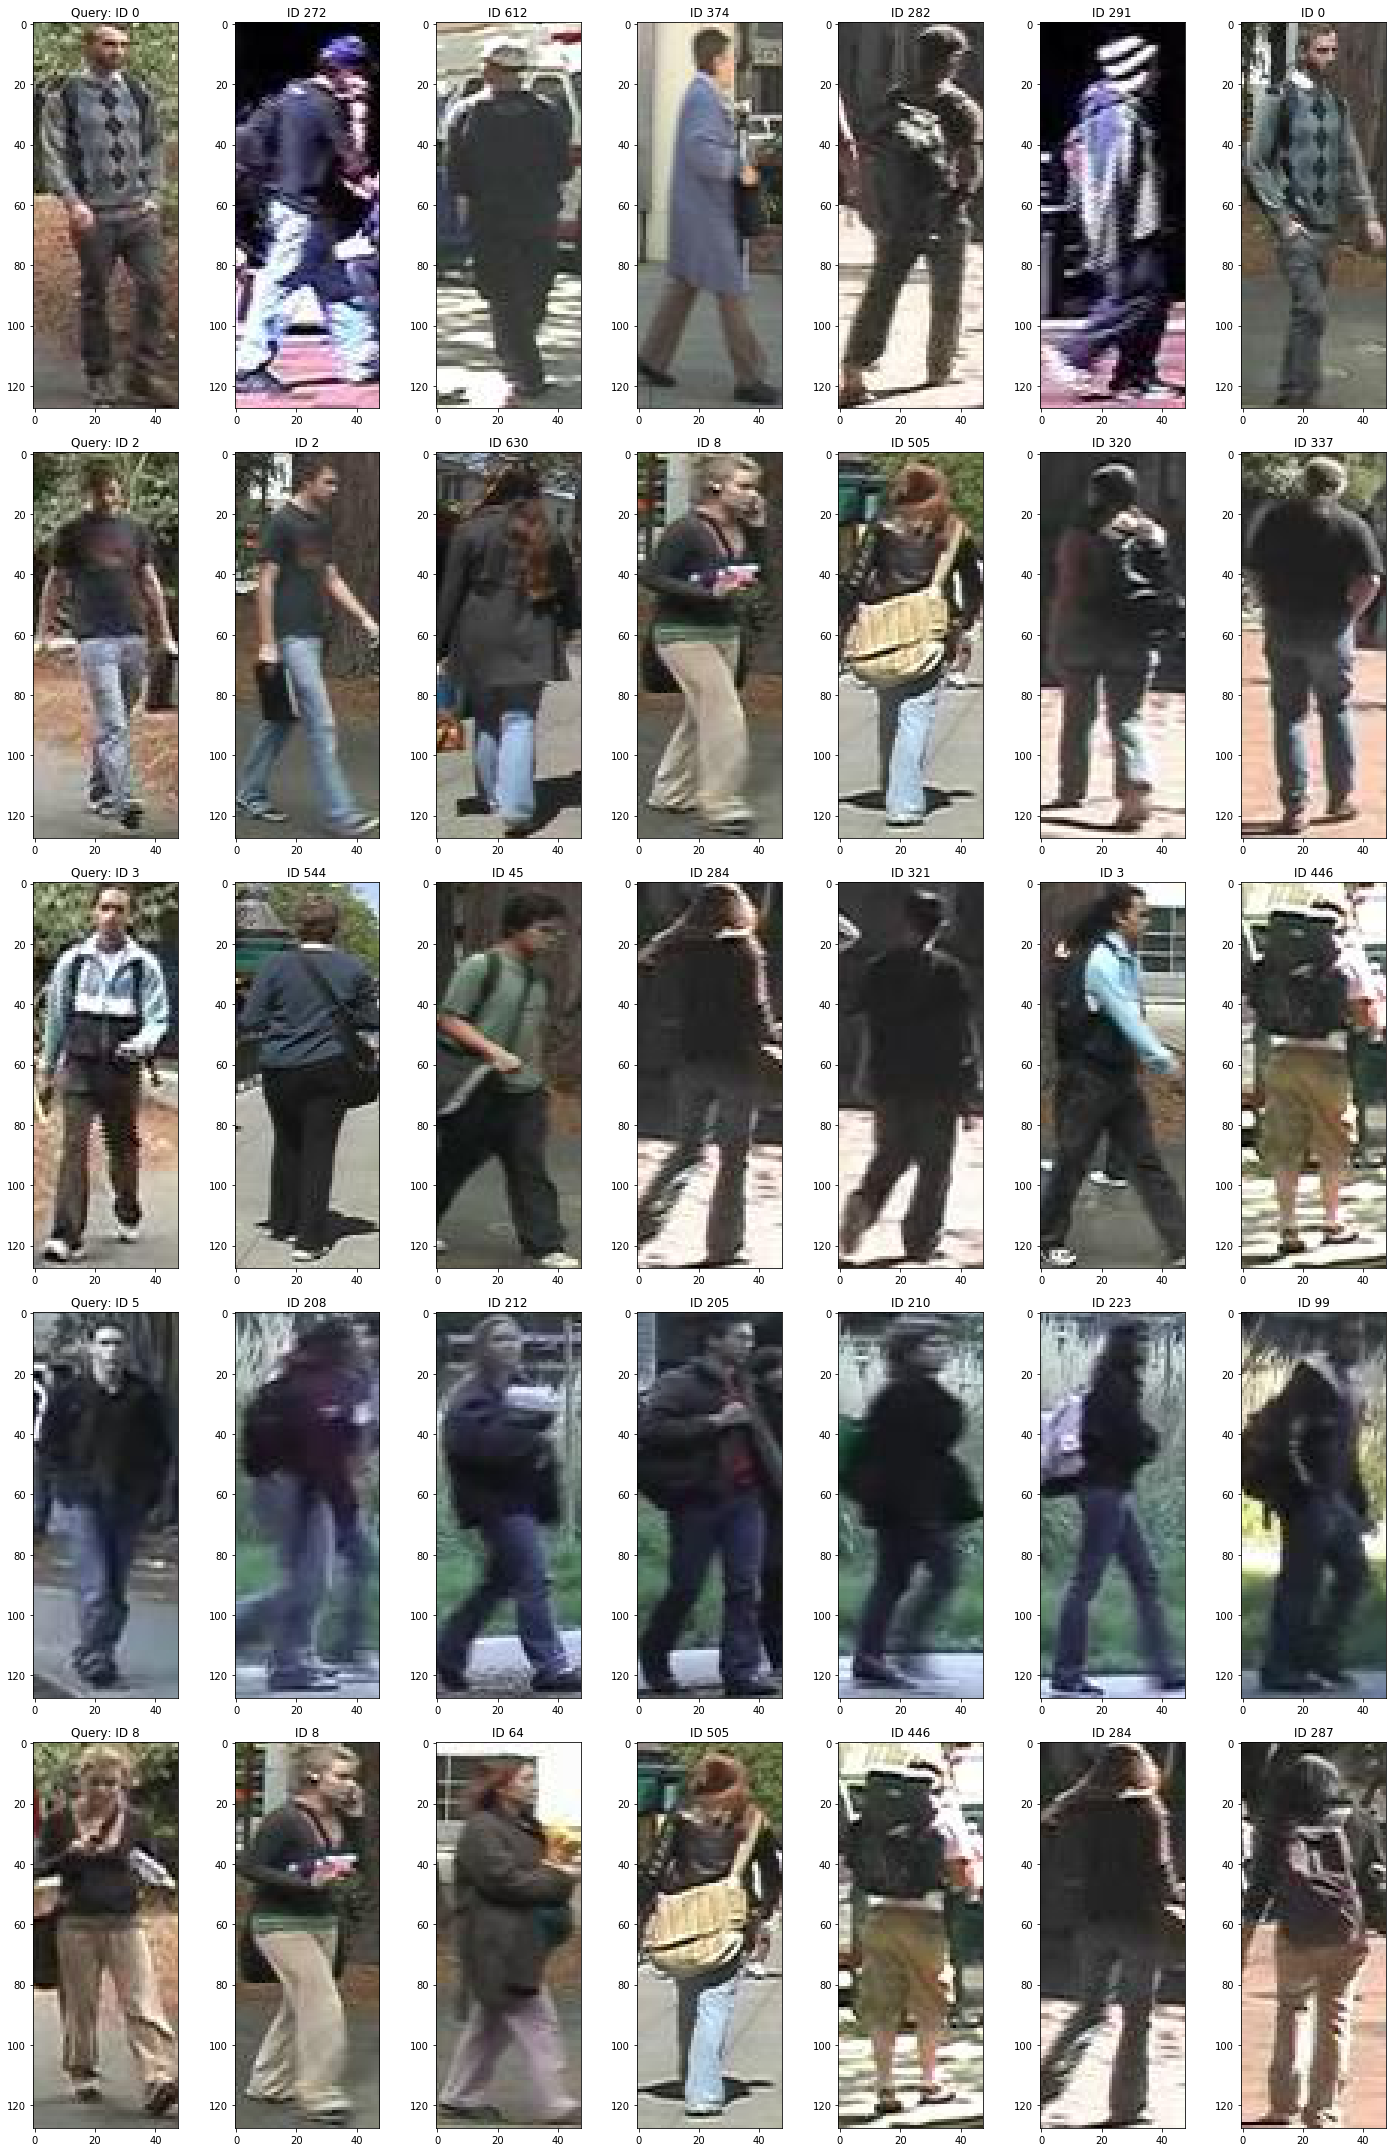

In [86]:
# Visualizando alguns rankings:
K = 6
N_cols = K+1

offset = 0

plt.figure(figsize=(20, 30))
for j in range(5):
    q_indice = querygal_split['query'][offset+j]
    #print(q_indice)
    ranking = rankings[offset+j, :K]
    #print(ranking)
    
    plt.subplot(5, K+1, (j*N_cols)+1)
    plt.imshow(X_querygal[q_indice])
    plt.title('Query: ID {}'.format(y_querygal[q_indice]))
    
    for i in range(K):
        plt.subplot(5, N_cols, (j*N_cols)+i+2)
        plt.imshow(X_querygal[ranking[i]])
        plt.title('ID {}'.format(y_querygal[ranking[i]]))
        
    plt.tight_layout()

### Visualizando um rank-10

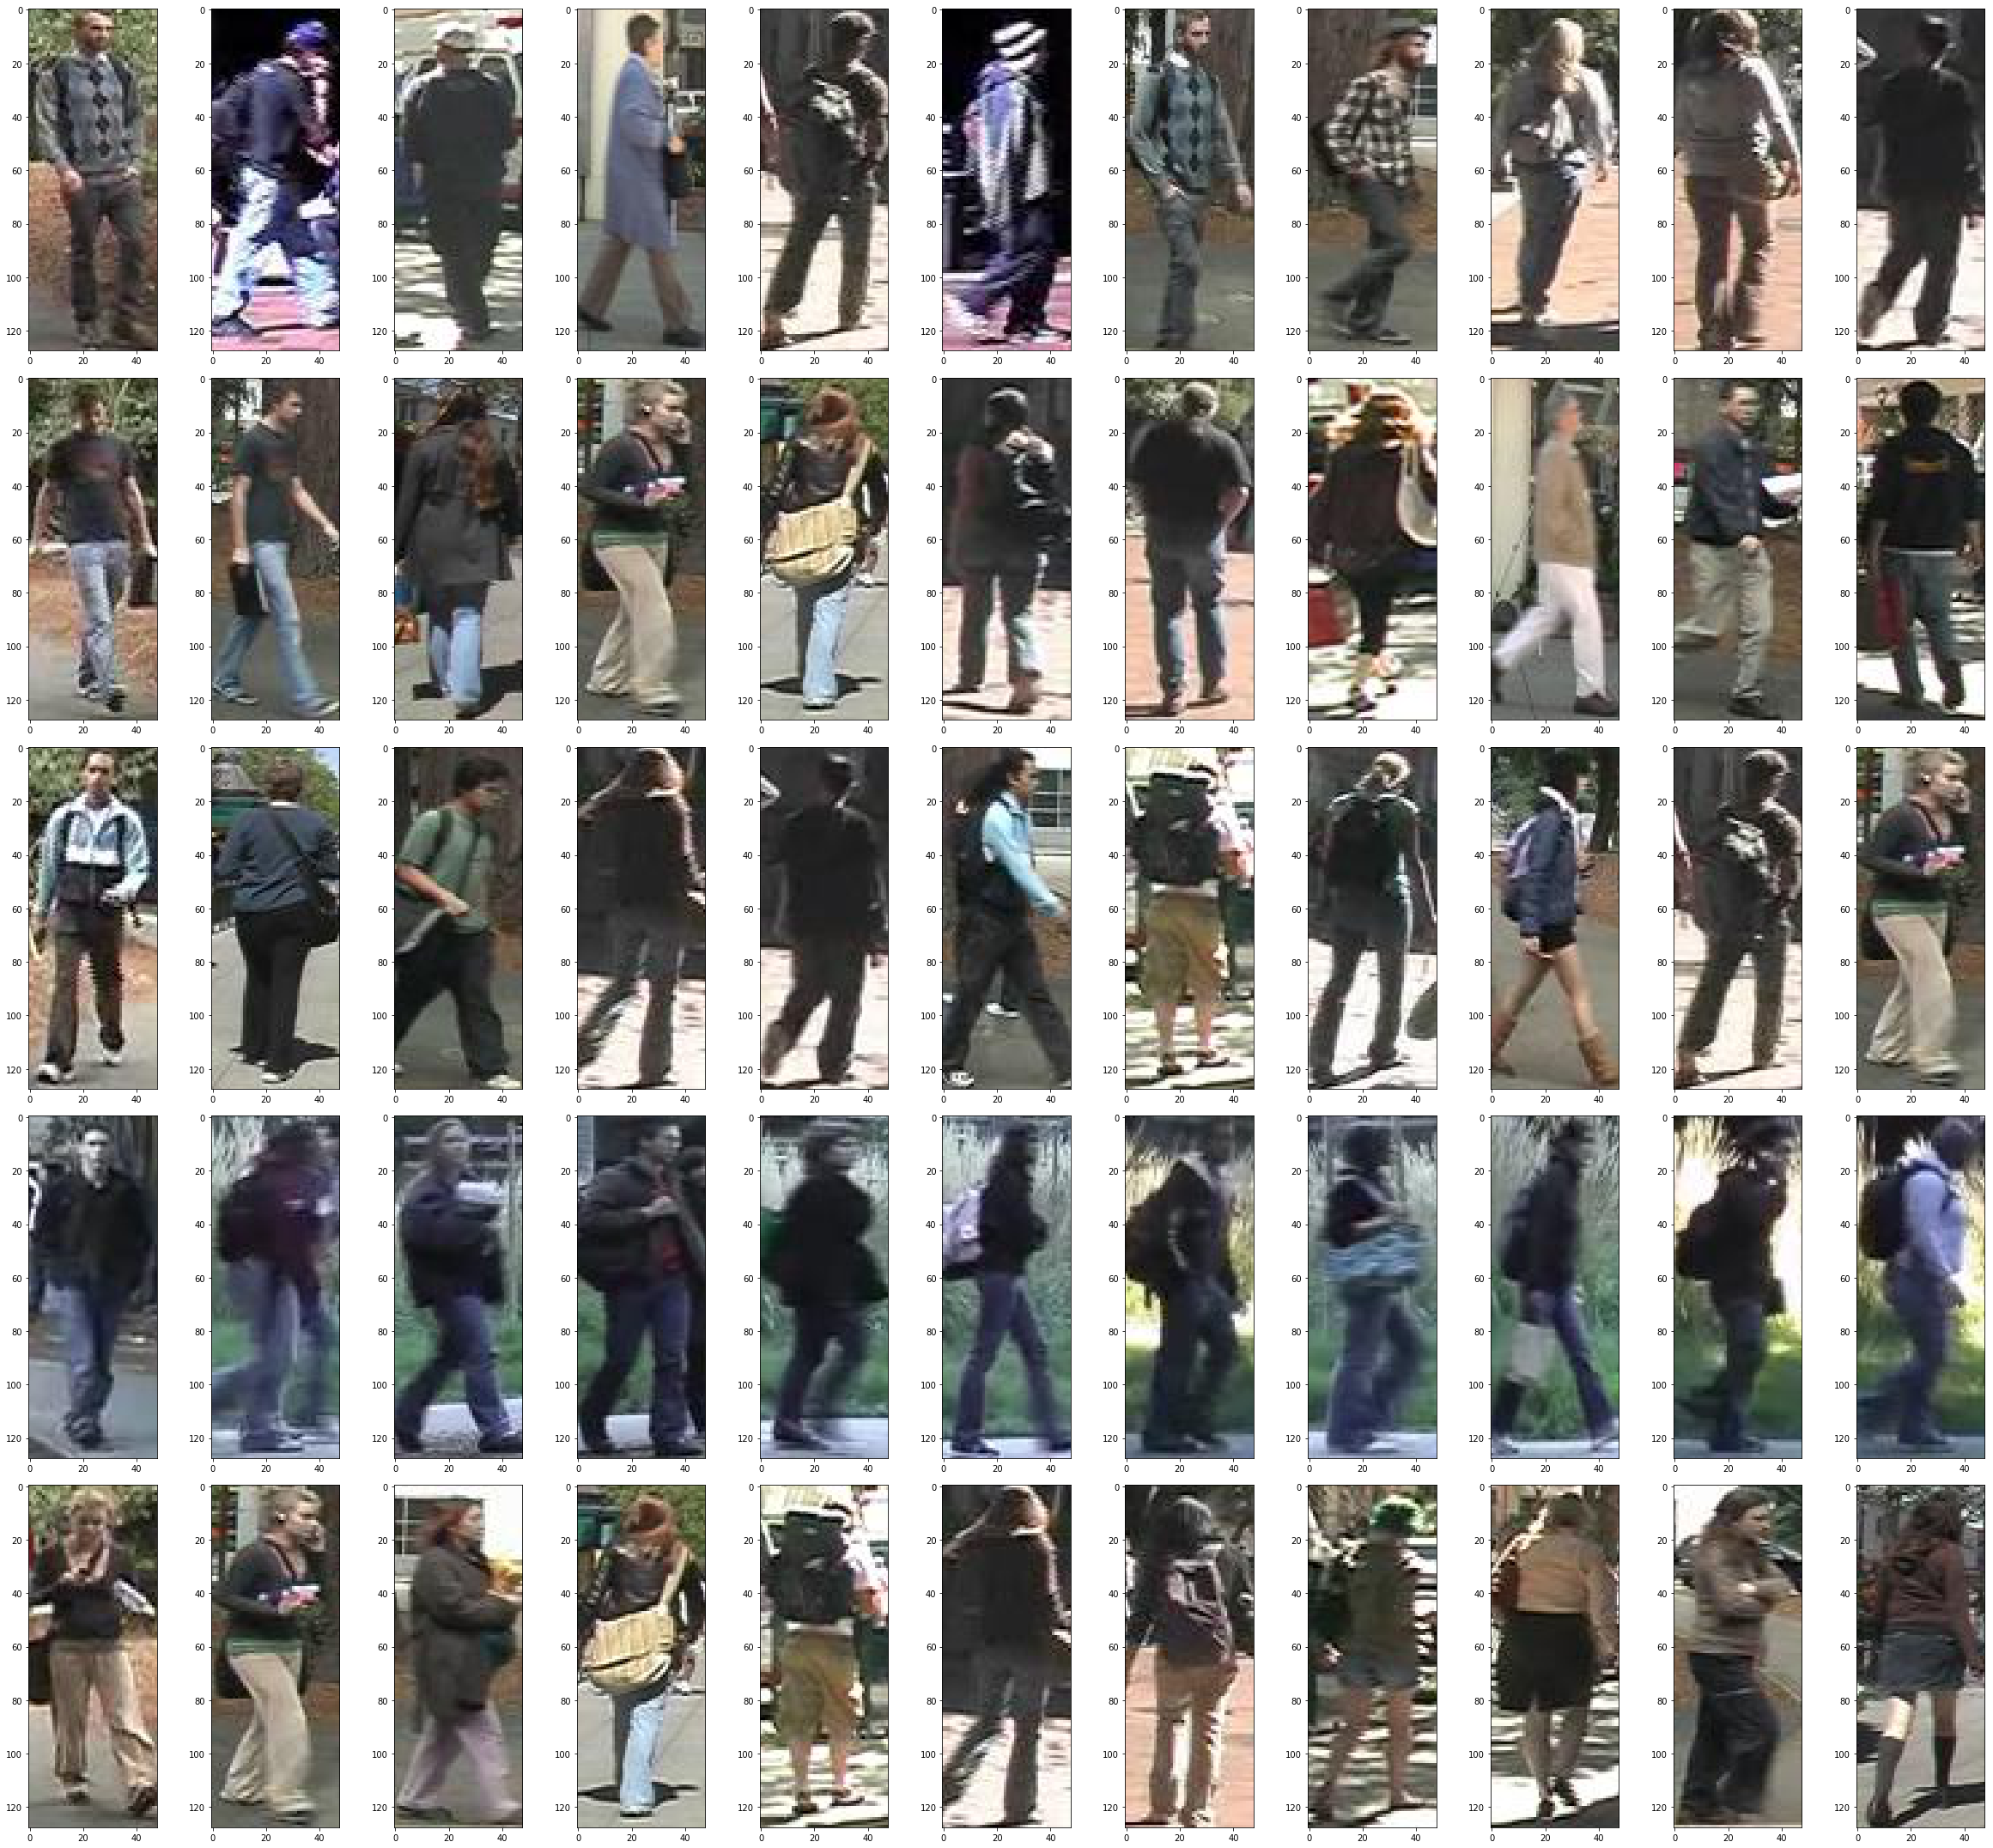

In [29]:
# Visualizando alguns rankings:
plt.figure(figsize=(33, 30))
for j in range(5):
    q_indice = querygal_split['query'][j]
    ranking = rankings[j, :]
    
    plt.subplot(5, 11, (j*11)+1)
    plt.imshow(X_querygal[q_indice])
    
    for i in range(10):
        plt.subplot(5, 11, (j*11)+i+2)
        plt.imshow(X_querygal[ranking[i]])
        
    plt.tight_layout()

In [36]:
query_pids = y_querygal[querygal_split['query']]
matched_pids = y_querygal[rankings]
print('Identidades de Query:')
print(query_pids[:20, np.newaxis])
print()
print('Identidades dos matches para cada Query (linha):')
print(matched_pids[:20])

Identidades de Query:
[[ 0]
 [ 2]
 [ 3]
 [ 5]
 [ 8]
 [10]
 [12]
 [17]
 [18]
 [20]
 [21]
 [22]
 [26]
 [27]
 [29]
 [30]
 [32]
 [33]
 [34]
 [35]]

Identidades dos matches para cada Query (linha):
[[272 612 374 282 291   0  51 333 275 321]
 [  2 630   8 505 320 337 490 403  26 513]
 [544  45 284 321   3 446 255  12 282   8]
 [208 212 205 210 223  99 160 207 119 107]
 [  8  64 505 446 284 287 512 607  34 589]
 [337 320  37 559 193  44  55 418   8 177]
 [ 12 446 607 609 459 287 512 592   8 494]
 [ 17  49 367 403 471 132 619 541 214 539]
 [381 528 626 299 110 463 201 187 326 601]
 [ 20  34  33 179 105 379  10 489 571  70]
 [ 21 509 371 190 404 272  55 446 364  12]
 [ 22   8  26 605 505 438 625 364  29 284]
 [ 26   8 625 540 364  22 403 509  17 497]
 [ 27   8 523  51 505 284 403  65 386 546]
 [  8  29 505  30 284 489 512 337 287 446]
 [ 30 287 269 589 284 505 282 292 336  29]
 [ 29 389 321  30 513 489 337   8  10 284]
 [251 200 282  33  51 589 188 433 571  20]
 [490 403 505 589   8 284 630  64

In [37]:
# rank-10 para esse split:
np.mean(np.sum(matched_pids[:, :10] == query_pids[:, np.newaxis], axis=1))

0.67721518987341767

In [38]:
def calculate_rank_k(k, query_pids, matched_pids):
    correct = 0
    # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
    # até a k-ésima posição
    for i, pid in enumerate(query_pids):
        if pid in matched_pids[i, :k]:
            correct += 1
            
    return correct / len(query_pids)


In [43]:
print('Rank-1: ', calculate_rank_k(1, query_pids, matched_pids))
print('Rank-5: ', calculate_rank_k(5, query_pids, matched_pids))
print('Rank-10: ', calculate_rank_k(10, query_pids, matched_pids))

Rank-1:  0.27531645569620256
Rank-5:  0.5348101265822784
Rank-10:  0.6772151898734177


# Cálculo do CMC

In [73]:
def calculate_cmc(y_querygal, cam_ids, features, N_splits=20, ranks=[1, 5, 10]):
    # Calcula as distâncias entre cada par de features
    distances = pairwise_squared_euclidian_distance(features, features)
    
    cmcs = {k: [] for k in ranks}

    
    # Para cada execução
    for n in range(N_splits):
        # Gera um split de Query e Galeria
        query_indices_by_cam = generate_query(y_querygal, cam_ids)
        
        for cam, indices in query_indices_by_cam.items():
            querygal_split = {
                'query': np.array(indices, dtype=np.intp),
                'gallery': get_gallery_for_cross_camera_search(cam_ids, cam_id=cam)
            }
            #if n < 2: print(querygal_split)
        
            rankings = querygal_split['gallery'][get_topk_results(distances, int(max(ranks)),
                                                              querygal_split).numpy()]
        
            query_pids = y_querygal[querygal_split['query']]
            matched_pids = y_querygal[rankings]
        
            for k in ranks:
                correct = 0
                # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
                # até a k-ésima posição
                for i, pid in enumerate(query_pids):
                    if pid in matched_pids[i, :k]:
                        correct += 1
            
                # média de acertos
                cmcs[k].append(correct / len(query_pids))

    for k, rank in cmcs.items():
        cmcs[k] = np.mean(rank)
    
    return cmcs

In [85]:
calculate_cmc(y_querygal, cam_ids, querygal_features, N_splits=20)

{1: 0.26740506329113928, 5: 0.545886075949367, 10: 0.68196202531645567}

# Cálculo mAP

In [75]:
# Para cada execução
N_executions = 50

mAPs = []

for n in range(N_executions):
    # Gera um split de Query e Galeria
    query_indices_by_cam = generate_query(y_querygal, cam_ids)
    
    mAPs.append(calculate_mAP(query_indices_by_cam, querygal_features, y_querygal, cam_ids))
    
print('mAP final: ', np.mean(mAPs))
#     rankings = querygal_split['gallery'][get_topk_results(distances, int(max(ranks)),
#                                                           querygal_split).numpy()]

#     query_pids = y_querygal[querygal_split['query']]
#     matched_pids = y_querygal[rankings]

#     for k in ranks:
#         correct = 0
#         # Para cada identidade (pid), verifica se ela está presente nas identidades retornadas pelo rank
#         # até a k-ésima posição
#         for i, pid in enumerate(query_pids):
#             if pid in matched_pids[i, :k]:
#                 correct += 1

#         # média de acertos
#         cmcs[k].append(correct / len(query_pids))

# for k, rank in cmcs.items():
#     cmcs[k] = np.mean(rank)

mAP final:  0.399282977231
